In [1]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow.keras.layers as tfl
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow.keras.metrics as metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay

2026-01-22 22:23:41.832027: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 22:23:41.932078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 22:23:43.257189: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(f"TensorFlow / Keras version: {tf.__version__}")

TensorFlow / Keras version: 2.20.0


In [3]:
SEED = 28
def seed_everthing(seed=SEED):
    """
    Sets the global random seeds for reproducibility across TensorFlow, NumPy, and Python's random module.
    
    Args:
        SEED (int): The integer seed value to be used.
    """
    # Set the seed for TensorFlow operations (both CPU and GPU)
    tf.random.set_seed(SEED)
    # Set the seed for NumPy's random number generator
    np.random.seed(SEED)
    # Set the seed for Python's built-in random module
    random.seed(SEED)

    print(f"For Reproducibilty, Everything seeded with seed: {SEED}")

seed_everthing()

For Reproducibilty, Everything seeded with seed: 28


In [4]:
def get_strategy():
    """
    Detects and returns the best TensorFlow distribution strategy.
    - TPUStrategy for TPU(s)
    - MirroredStrategy for GPU(s)
    - Default strategy for CPU
    """
    try:
        # Try TPU first
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Using TPU strategy:", type(strategy).__name__)
    except Exception:
        # If TPU not available, try GPU
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            strategy = tf.distribute.MirroredStrategy()
            print("Using GPU strategy:", type(strategy).__name__)
        else:
            # Fallback CPU
            strategy = tf.distribute.get_strategy()
            print("No TPU/GPU found. Using CPU strategy:", type(strategy).__name__)

    print("REPLICAS:", strategy.num_replicas_in_sync)
    return strategy

In [5]:
# --- ADD THIS FIX AT THE TOP OF YOUR SCRIPT ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to be enabled for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
# --- END OF FIX ---

Enabled memory growth for 1 GPU(s)


In [6]:
strategy = get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU strategy: MirroredStrategy
REPLICAS: 1


I0000 00:00:1769108024.822125   33039 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [7]:
AUTO = tf.data.AUTOTUNE
DATA_DIR = '../../data/'
MODELS_DIR = '../models/classification/'
LOG_DIR = '../logs/classification/densenet/'
HPARAMS_DIR = './optuna/phase2_optimization/healthy_unhealthy-best_hparams.json'
IMG_SIZE = (256, 256)
MASK_SIZE = IMG_SIZE
SHUFFLE_SIZE = 1024
WARMUP_EPOCH = 5
FINAL_EPOCH = 50
OVERFIT_THRESHOLD = 0.025
UNFREEZE_LAYER = "conv5_block1_0_bn"
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
DATASET_CONFIG = {'shuffle': SHUFFLE_SIZE, 'batch_size': BATCH_SIZE, 'auto': AUTO}
MODEL_CONFIG = {'img_size': IMG_SIZE, 'mask_size': MASK_SIZE}
print(f"Global Batch Size: {BATCH_SIZE}")

Global Batch Size: 8


In [8]:
warmup_model_path = os.path.join(MODELS_DIR, 'warmup_densenet_binary_healthy_model.keras')
final_model_path = os.path.join(MODELS_DIR, 'final_densenet_binary_healthy_model.keras')

In [9]:
class_mapping_path = os.path.join(DATA_DIR, 'class_mapping.json')
with open(class_mapping_path, 'r') as f:
    class_mapping = json.load(f)

print(class_mapping)

{'COVID': 0, 'Normal': 1, 'Viral Pneumonia': 2, 'Lung_Opacity': 3}


In [10]:
binary_healthy_mapping_path = os.path.join(DATA_DIR, 'healthy_binary_mapping.json')
with open(binary_healthy_mapping_path, 'r') as f:
    binary_healthy_mapping = json.load(f)

print(binary_healthy_mapping)

{'Healthy': 0, 'Unhealthy': 1}


In [11]:
def parse_fn(example, config=MODEL_CONFIG):
    '''
    Parses a single TFRecord example, decoding and resizing the image and mask.

    Returns:
        tuple: (img, mask, label) tensors after initial decoding and resizing.
    '''
    img_size = config["img_size"]
    mask_size = config["mask_size"]
    # Define the dictionary of features expected in the TFRecord
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64)
    }

    # Parse the input record
    example = tf.io.parse_single_example(example, feature_description)
    
    # Decode image and mask
    img = tf.io.decode_png(example['image'], channels= 3)
    mask = tf.io.decode_png(example['mask'], channels= 1)

    # Resize image using bilinear interpolation for quality
    img = tf.image.resize(img, img_size, method= 'bilinear')
    img = tf.cast(img, tf.float32)

    # Resize mask using nearest neighbor to preserve boundaries
    mask = tf.image.resize(mask, mask_size, method= 'nearest')
    # Normalize and ensure binarization (0.0 or 1.0)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.round(mask)

    # Return label also
    label = tf.cast(example['class'], tf.int32)

    return img, mask, label

In [12]:
def lung_roi_preprocess(image, mask, label):
    mask_2d = tf.cast(mask[:, :, 0], tf.float32)
    indices = tf.where(mask_2d > 0.5)

    img_shape = tf.shape(image)

    def crop():
        min_coords = tf.cast(tf.reduce_min(indices, axis=0), tf.int32)
        max_coords = tf.cast(tf.reduce_max(indices, axis=0), tf.int32)

        y_min = min_coords[0]
        x_min = min_coords[1]
        y_max = max_coords[0]
        x_max = max_coords[1]

        h = tf.cast(y_max - y_min, tf.float32)
        w = tf.cast(x_max - x_min, tf.float32)

        margin_y = tf.cast(h * 0.1, tf.int32)
        margin_x = tf.cast(w * 0.1, tf.int32)

        y_start = tf.maximum(0, y_min - margin_y)
        x_start = tf.maximum(0, x_min - margin_x)
        y_end = tf.minimum(img_shape[0], y_max + margin_y)
        x_end = tf.minimum(img_shape[1], x_max + margin_x)

        final_h = tf.maximum(y_end - y_start, 1)
        final_w = tf.maximum(x_end - x_start, 1)

        cropped = tf.image.crop_to_bounding_box(
            image, y_start, x_start, final_h, final_w
        )
        return tf.image.resize(cropped, (256, 256))

    def fallback():
        return tf.image.resize(image, (256, 256))

    image = tf.cond(tf.shape(indices)[0] > 0, crop, fallback)

    return image, label

In [13]:
def remap_for_binary(image, label):
    '''
    Remaps the multiclass label (where 1 is one class, and others are combined) into a binary (0 or 1) float label.

    Args:
        image (tf.Tensor): Input image tensor.
        mask (tf.Tensor): Input mask tensor.
        label (tf.Tensor): Input integer label.

    Returns:
        tuple: (image, mask, new_label) where new_label is a binary float tensor.
    '''
    # Map original label 1 to 0, and all others to 1 (binary classification), because as we see in class mapping
    # Normal images has Label 1
    new_label = tf.where(tf.equal(label, 1), 0, 1)
    new_label = tf.cast(new_label, tf.float32)
    # Ensure label is in the correct shape for binary classification output (e.g., [1])
    new_label = tf.expand_dims(new_label, axis= -1)
    
    return image, new_label

In [14]:
image_augmentation = tf.keras.Sequential([
    tfl.RandomFlip('horizontal'),
    tfl.RandomRotation(0.1, interpolation='bilinear', fill_mode='nearest'),
    tfl.RandomZoom(0.1, interpolation='bilinear', fill_mode='nearest'),
    tfl.RandomBrightness(0.1),
    tfl.RandomContrast(0.1)
])

In [15]:
def binary_dataset(tfrecords, config, is_training= True, image_augmentation=None):
    shuffle_size = config["shuffle"]
    batch_size = config["batch_size"]
    AUTO = config["auto"]
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads= AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(parse_fn, num_parallel_calls=AUTO)
    dataset = dataset.map(lung_roi_preprocess, num_parallel_calls=AUTO)
    dataset = dataset.map(remap_for_binary, num_parallel_calls=AUTO)
    
    if is_training:
        dataset = dataset.shuffle(shuffle_size)
        # 1. Batch the data FIRST
        dataset = dataset.batch(batch_size, drop_remainder= True)
        # 2. Apply augmentation to the entire batch SECOND
        if image_augmentation is not None:
            dataset = dataset.map(
                lambda x, y: (image_augmentation(x, training=True), y), 
                num_parallel_calls= AUTO
            )
    else:
        # For validation, just batch the data without augmenting
        dataset = dataset.batch(batch_size, drop_remainder= True)

    dataset = dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls= AUTO)
    # 3. Prefetch the augmented batches
    dataset = dataset.prefetch(AUTO)
    return dataset

In [16]:
all_files = tf.io.gfile.glob(os.path.join(DATA_DIR, 'tfrecords/*.tfrecord'))
train_files = all_files[1:]
val_files = all_files[:1]
print(
    f"Train files: {train_files}\n"
    f"Val files: {val_files}"
)

Train files: ['../../data/tfrecords/data_01.tfrecord', '../../data/tfrecords/data_02.tfrecord', '../../data/tfrecords/data_03.tfrecord', '../../data/tfrecords/data_04.tfrecord', '../../data/tfrecords/data_05.tfrecord', '../../data/tfrecords/data_06.tfrecord', '../../data/tfrecords/data_07.tfrecord', '../../data/tfrecords/data_08.tfrecord', '../../data/tfrecords/data_09.tfrecord']
Val files: ['../../data/tfrecords/data_00.tfrecord']


In [17]:
train_dataset = binary_dataset(
    train_files, config=DATASET_CONFIG, is_training=True, image_augmentation=image_augmentation
)
val_dataset = binary_dataset(
    val_files, config=DATASET_CONFIG, is_training=False, image_augmentation=None
)
print("Train and Valdiation Dataset are created successfully!")

Train and Valdiation Dataset are created successfully!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0657127].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0154798..2.632325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0201988..2.460306].


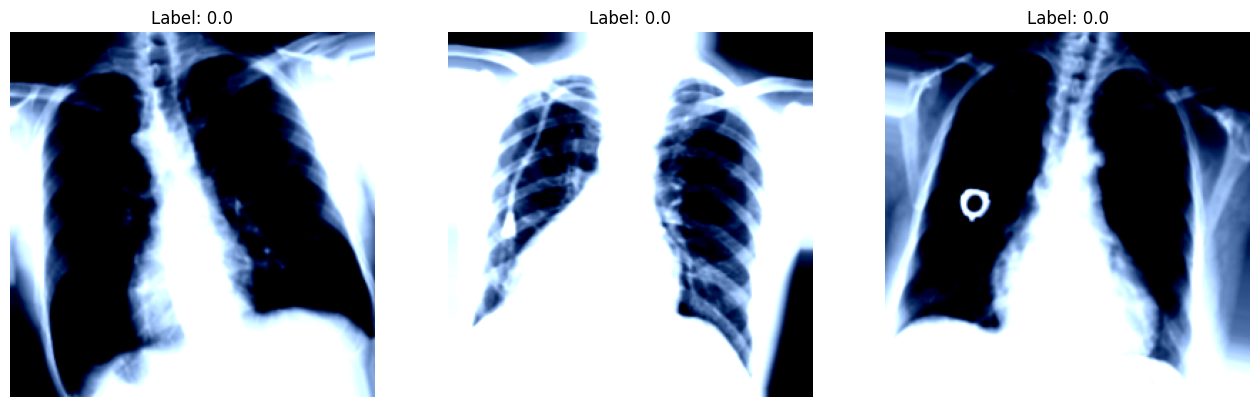

In [41]:
for img, label in train_dataset.take(1):
    fig, axes = plt.subplots(1, 3, figsize= (16, 9))
    for i, ax in enumerate(axes):
        ax.imshow(img[i].numpy())
        ax.set_title(f"Label: {label[i][0]}")
        ax.axis("off")
    plt.show()

In [18]:
def count_steps(tfrecords):
    '''
    Counts the total number of examples across a list of TFRecord files.

    Args:
        tfrecords (list): List of TFRecord file paths.

    Returns:
        int: The total count of examples.
    '''
    count = 0
    for tfrecord in tfrecords:
        count += sum(1 for _ in tf.data.TFRecordDataset(tfrecord))
    return count

train_samples = count_steps(train_files)
val_samples = count_steps(val_files)
# Calculate steps based on sample counts and batch size
steps_per_epoch = math.ceil(train_samples / BATCH_SIZE)
validation_steps = math.ceil(val_samples / BATCH_SIZE)
print(
    f'Steps Per Epoch: {steps_per_epoch}\n'
    f'Validation steps: {validation_steps}'
)

2026-01-22 22:23:46.973587: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144
2026-01-22 22:23:47.578575: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-22 22:23:48.350533: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-22 22:23:49.599598: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-22 22:23:51.915210: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Steps Per Epoch: 2381
Validation steps: 265


In [19]:
with open(HPARAMS_DIR, 'r') as f:
    hparams_metadata = json.load(f)
print(
    f"Optuna metadata results: {hparams_metadata}\n\n\n"
    f"Best Hyperparameters: {hparams_metadata['best_hparams']}"
)
MODEL_CONFIG["best_hparams"] = hparams_metadata['best_hparams']

Optuna metadata results: {'best_trial_number': 10, 'best_value': 0.8967769437770365, 'best_hparams': {'num_layers': 2, 'dense_units': [1024, 512], 'lr_stage1': 0.0008824906998131688, 'lr_stage2': 2.0474913006882903e-05, 'weight_decay': 1.0450737163016266e-05, 'label_smoothing': 0.075, 'dropout_rate': 0.25}, 'phase2_settings': {'loss': 'BinaryCrossentropy', 'optimizer': 'AdamW', 'lr_schedules': 'CosineDecay', 'warmup_epochs': 3, 'unfreeze_epochs': 5, 'unfreeze_layer': 'conv5_block1_0_bn', 'trials': 20}, 'timestamp': 1769012453.2206218, 'seed': 28}


Best Hyperparameters: {'num_layers': 2, 'dense_units': [1024, 512], 'lr_stage1': 0.0008824906998131688, 'lr_stage2': 2.0474913006882903e-05, 'weight_decay': 1.0450737163016266e-05, 'label_smoothing': 0.075, 'dropout_rate': 0.25}


In [20]:
def densenet_model(config):
    img_size = config['img_size']
    hparams = config['best_hparams']
    dense_units = hparams['dense_units']
    num_layers = hparams['num_layers']
    dropout_rate = hparams['dropout_rate']
    inputs = tfl.Input(shape=img_size + (3,))
    base_model = DenseNet121(
        name='densenet',
        weights='imagenet',
        include_top=False
    )
    base_model.trainable = False
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
    dn = base_model(inputs, training=True)
    x = tfl.GlobalAveragePooling2D()(dn)
    for i in range(num_layers):
        units = dense_units[i]
        x = tfl.Dense(units, activation='relu', name=f"dense_layer_{i}")(x)
        dropout = tfl.Dropout(dropout_rate, name=f"dropout_{i}")
        x = dropout(x, training=True)

    outputs = tfl.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [21]:
WARMUP_LR = MODEL_CONFIG["best_hparams"]["lr_stage1"]
WEIGHT_DECAY = MODEL_CONFIG["best_hparams"]["weight_decay"]
with strategy.scope():
    model = densenet_model(config=MODEL_CONFIG)
    loss = BinaryCrossentropy()
    optimizer = AdamW(
        learning_rate=WARMUP_LR,
        weight_decay=WEIGHT_DECAY
    )
    metrics_list = [
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='AUC')
    ]
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics_list
    )

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet (Functional)           │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_0 (Dense)           │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,612,417 (32.85 MB)

 Trainable params: 1,574,913 (6.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [46]:
checkpoint_cb = ModelCheckpoint(
    warmup_model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
tb_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1
)
callbacks = [checkpoint_cb, tb_cb]

In [47]:
history = model.fit(
    train_dataset.repeat(),
    validation_data=val_dataset.repeat(),
    epochs=WARMUP_EPOCH,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2026-01-22 01:06:38.034208: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2026-01-22 01:06:39.331904: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


2381/2381 ━━━━━━━━━━━━━━━━━━━━ 292s 118ms/step - AUC: 0.9082 - accuracy: 0.8325 - loss: 0.3807 - precision: 0.8571 - recall: 0.8125 - val_AUC: 0.9331 - val_accuracy: 0.8547 - val_loss: 0.3257 - val_precision: 0.9149 - val_recall: 0.7933
Epoch 2/5
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 279s 117ms/step - AUC: 0.9316 - accuracy: 0.8635 - loss: 0.3293 - precision: 0.8918 - recall: 0.8383 - val_AUC: 0.9352 - val_accuracy: 0.8561 - val_loss: 0.3206 - val_precision: 0.8969 - val_recall: 0.8160
Epoch 3/5
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 278s 116ms/step - AUC: 0.9372 - accuracy: 0.8709 - loss: 0.3146 - precision: 0.8975 - recall: 0.8478 - val_AUC: 0.9427 - val_accuracy: 0.8642 - val_loss: 0.3074 - val_precision: 0.8851 - val_recall: 0.8480
Epoch 4/5
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 277s 116ms/step - AUC: 0.9401 - accuracy: 0.8740 - loss: 0.3081 - precision: 0.9000 - recall: 0.8516 - val_AUC: 0.9444 - val_accuracy: 0.8670 - val_loss: 0.2945 - val_precision: 0.8908 - val_recall: 0.8470
Epoch 5/5
2381/2381 ━━

In [22]:
def unfreeze_backbone(model, backbone_name= None, unfreeze_layer= None):
    base_model = model.get_layer(backbone_name)
    
    if unfreeze_layer is None:
        # Stage 1: Freeze everything
        base_model.trainable = False
        return model

    # Stage 2: Selective Unfreezing
    base_model.trainable = True
    unfreeze_flag = False
    
    for layer in base_model.layers:
        if layer.name == unfreeze_layer:
            unfreeze_flag = True
        
        if unfreeze_flag:
            # PROFESSIONAL RULE: Always keep BatchNormalization frozen during fine-tuning
            # to avoid destroying the moving mean/variance statistics.
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True
        else:
            layer.trainable = False
            
    return model

In [23]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * p * r / (p + r + 1e-7)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [24]:
FINAL_LR = MODEL_CONFIG["best_hparams"]["lr_stage2"]
WEIGHT_DECAY = MODEL_CONFIG["best_hparams"]["weight_decay"]
LABEL_SMOOTHING = MODEL_CONFIG["best_hparams"]["label_smoothing"]
with strategy.scope():
    model = load_model(warmup_model_path)
    model = unfreeze_backbone(
        model, backbone_name='densenet', unfreeze_layer=UNFREEZE_LAYER
    )
    model.summary()
    loss = BinaryCrossentropy(
        label_smoothing=LABEL_SMOOTHING
    )
    decay_steps = FINAL_EPOCH * steps_per_epoch
    lr = CosineDecay(
        initial_learning_rate=FINAL_LR,
        decay_steps=decay_steps,
        alpha=0.0
    )
    optimizer = AdamW(
        learning_rate=lr,
        weight_decay=WEIGHT_DECAY
    )
    metrics_list = [
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='AUC'),
        F1Score(name='f1')
    ]
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics_list
    )
    

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet (Functional)           │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_0 (Dense)           │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,762,245 (44.87 MB)

 Trainable params: 3,704,833 (14.13 MB)

 Non-trainable params: 4,907,584 (18.72 MB)

 Optimizer params: 3,149,828 (12.02 MB)

In [25]:
checkpoint_cb = ModelCheckpoint(
    final_model_path,
    monitor='val_f1',
    mode='max',
    save_best_only=True
)
earlystopping_cb = EarlyStopping(
    patience= math.ceil(FINAL_EPOCH // 10),
    monitor='val_loss',
    min_delta= 1e-3,
    mode='min',
)
tb_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1
)
callbacks = [
    checkpoint_cb,
    earlystopping_cb,
    tb_cb
]

In [26]:
history = model.fit(
    train_dataset.repeat(),
    validation_data=val_dataset.repeat(),
    initial_epoch=WARMUP_EPOCH,
    epochs=FINAL_EPOCH,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2026-01-22 22:24:13.059505: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2026-01-22 22:24:14.240495: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


2381/2381 ━━━━━━━━━━━━━━━━━━━━ 323s 131ms/step - AUC: 0.9509 - accuracy: 0.8880 - f1: 0.8898 - loss: 0.3668 - precision: 0.9085 - recall: 0.8718 - val_AUC: 0.9575 - val_accuracy: 0.8887 - val_f1: 0.8872 - val_loss: 0.3545 - val_precision: 0.9336 - val_recall: 0.8452
Epoch 7/50
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 313s 131ms/step - AUC: 0.9585 - accuracy: 0.8978 - f1: 0.8994 - loss: 0.3477 - precision: 0.9180 - recall: 0.8816 - val_AUC: 0.9606 - val_accuracy: 0.8953 - val_f1: 0.8935 - val_loss: 0.3468 - val_precision: 0.9452 - val_recall: 0.8471
Epoch 8/50
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 311s 130ms/step - AUC: 0.9637 - accuracy: 0.9086 - f1: 0.9106 - loss: 0.3312 - precision: 0.9238 - recall: 0.8977 - val_AUC: 0.9648 - val_accuracy: 0.9000 - val_f1: 0.9035 - val_loss: 0.3361 - val_precision: 0.9035 - val_recall: 0.9035
Epoch 9/50
2381/2381 ━━━━━━━━━━━━━━━━━━━━ 311s 130ms/step - AUC: 0.9682 - accuracy: 0.9162 - f1: 0.9179 - loss: 0.3180 - precision: 0.9326 - recall: 0.9037 - val_AUC: 0.9656 - v